# Data Scientist Assignment


In this task, you will work with a sample dataset containing ad impression and click data.

The primary objective of this assignment is to analyze the data, derive meaningful insights, and build predictive models based on the patterns you uncover, to ultimatly improve click prediction.


# 0. Data Description


The dataset provided has been undersampled to ensure that clicks represent 5% of the total data, as opposed to the original 0.4%. It consists of one week of advertising data from Finland where one row represents an ad impression (view). The data includes the following features:

- Label: A binary feature indicating whether the ad was clicked (1) or not (0).
- art: The ad ID.
- loc: The site ID, representing the website where the ad appeared.
- tag: The placement ID assigned by the site to indicate the ad slot on the site where the ad was shown.
- dt: The device type on which the ad was displayed (mobile, tablet, or desktop).
- type: The type of advertisement, either banner or native.
- os: The operating system of the device.
- lt: The local time when the ad was displayed.
- make: The make (manufacturer) of the device.
- client: The client ID representing the advertiser.
- lang: The language of the browser.
- cl: The number of clicks the ad has received.


## 1. Loading the data & exploration


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets
from IPython.display import display

warnings.filterwarnings("ignore")

from utils import *

# Load dataset:
df = pd.read_feather("readpeak_data.feather")
df.head()

,art,loc,tag,dt,type,os,lt,make,client,city,lang,cl,label
9037056,6cb6aadc,4be84111,95e44e1c,mobile,native,Android,2022-06-10T01:56:49.332Z,Samsung,3234052e,eb1c296c,en,72,0
1493784,d7ac4cc4,a9346b00,c138f7fa,desktop,native,None,2022-06-12T09:32:13.555Z,None,79e89163,aa56ab48,None,467,0
6637725,9c1ddd84,be4b2f45,6438275c,desktop,native,None,2022-06-07T18:04:11.615Z,None,ae8046da,0cf4e8a7,None,27,0
1781706,00b396ac,68e476b5,0ed73eeb,desktop,native,None,2022-06-08T10:04:41.808Z,None,ae8046da,None,None,519,0
17525502,426595c6,5d389f5e,21c6d6a0,mobile,native,AndroidOS,2022-06-11T13:07:09.077Z,GenericPhone,5f96ea9c,ce81d3d8,None,84,0


### 1.1. Data Cleaning


### What potential challenges can you identify from the given data? and give a brief explanation how you would address them?


In [2]:
# Remove duplicates:
print(f"Number of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicates: 113


In [3]:
# Ensure correct data types:
df["lt"] = pd.to_datetime(df["lt"])
df["hour"] = df["lt"].map(lambda t: t.hour)
df["weekday"] = df["lt"].map(lambda t: t.weekday())

# Lowercase and strip whitespace all string columns:
df = df.applymap(lambda s: s.lower().strip() if type(s) == str else s)

In [4]:
# Normalize "os", "lang", and "make":
df["os"] = df["os"].apply(normalize_os)
df["lang"] = df["lang"].apply(normalize_lang)
df["make"] = df["make"].apply(normalize_make)

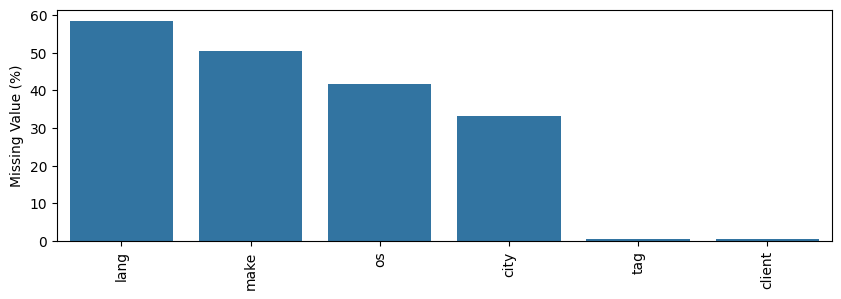

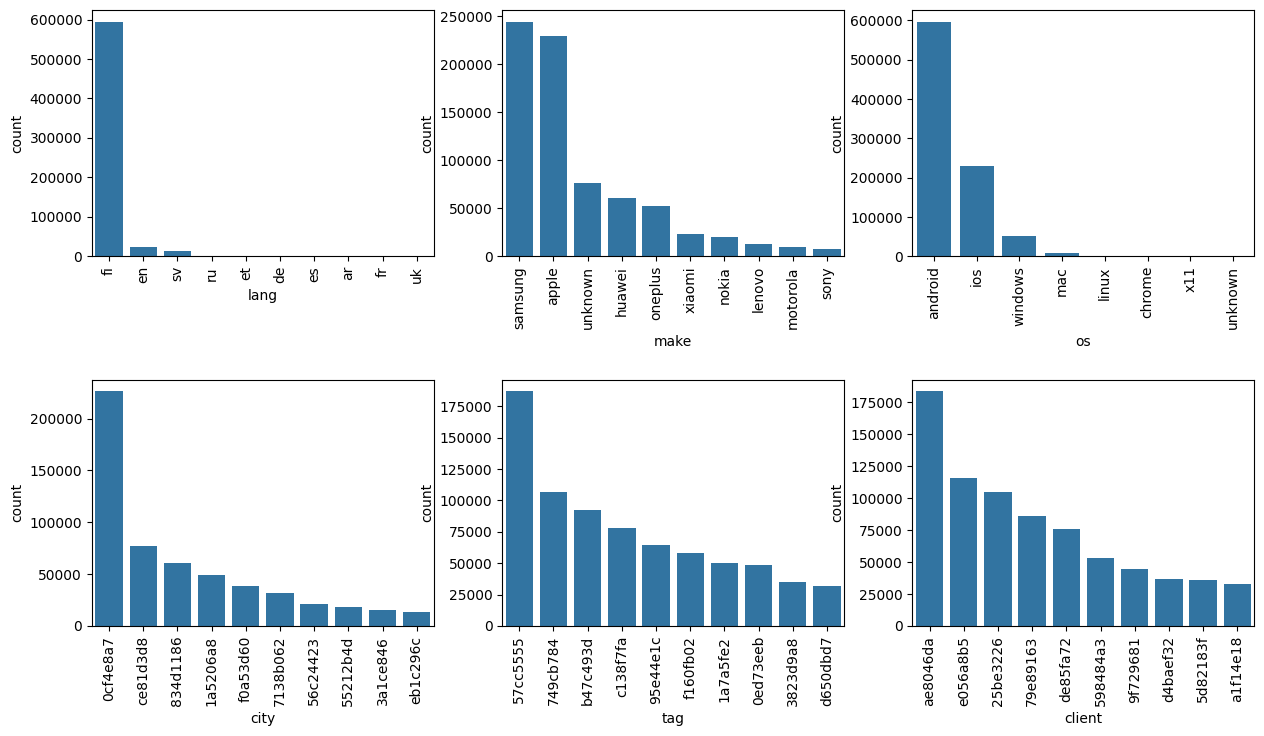

In [5]:
# Plot percentage of missing data:
missings = (df.isnull().mean() * 100).round(2).sort_values()
barplot(missings.loc[missings > 0], ylabel="Missing Value (%)", figsize=(10, 3))

# Plot data distribution:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)
cols = missings.loc[missings > 0][::-1].index

top = 10
for i in range(2):
    for j in range(3):
        col = cols[3 * i + j]
        sns.countplot(
            x=col,
            data=df,
            order=df[col].value_counts().nlargest(top).index,
            ax=axes[i, j],
        )
        axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)

From the plot, we can see that:

- Almost 60% of **"lang"** are missing, and it's heavily skewed to **fi**. The data are collected in Finland, so it's very likely that the missing values are mostly **fi**. There is also no information about the language of the ads, so imputing those missing values probably won't help much for the prediction.
- **"make"**, **"os"**, **"city"**, **"client"**, **"tag"** missing values will be imputed with **unknown**.


In [6]:
# Drop "lang" column:
df = df.drop("lang", axis=1)

# Impute missing values with "unknown":
df = df.fillna("unknown")

In [7]:
# Check data integrity:
print(
    "Click data are all non-negative integer"
    if (df["cl"] < 0).sum() == 0
    else "There is negative click data!"
)
print(
    "Label data are all binary"
    if df["label"].apply(lambda l: l in [0, 1]).all()
    else "There is non binary label data!"
)

Click data are all non-negative integer
Label data are all binary


In [8]:
# Reset index:
df.reset_index(drop=True, inplace=True)

### 1.2 Exploratory Data Analysis


#### Univariate Analysis


In [9]:
from utils import *

columns = [
    "art",
    "loc",
    "tag",
    "dt",
    "type",
    "os",
    "make",
    "client",
    "city",
    "hour",
    "weekday",
    "cl",
]

# Create tab widget
tab = widgets.Tab()

# Prepare an empty list for the output widgets
outputs = []

for i, column in enumerate(columns):
    if column == "cl":
        fig, ax = plt.subplots(1, 1, figsize=(15, 3))
        ax.set_title(f"{column.capitalize()}", fontsize=14)
        sns.kdeplot(df, x="cl", fill=True, ax=ax)
        plt.close(fig)
    else:
        fig = plot_category_vs_ctr(df, column, 50)

    # Create an output widget for each plot
    output = widgets.Output()

    with output:
        # Display the figure in the output widget
        display(fig)

    # Append the output widget to the outputs list
    outputs.append(output)

# Set the tab children to the list of outputs
tab.children = outputs
tab.titles = columns

# Display the tab widget
display(tab)

#### Multivariate Analysis


In [21]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Function to update the plot based on slider value
def update_plot(slider_val):
    x = np.linspace(0, 2 * np.pi, 100)
    y = np.sin(x * slider_val)

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_title(f'Sine wave with frequency {slider_val}')
    ax.grid(True)
    plt.show()

# Slider widget
slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Frequency')

# Output widget to display matplotlib plot
plot_output = widgets.Output()

# Update the plot when the slider value changes
def on_slider_change(change):
    with plot_output:
        plot_output.clear_output(wait=True)
        update_plot(change['new'])

slider.observe(on_slider_change, names='value')

# Initialize the plot
with plot_output:
    update_plot(slider.value)

# Tab 1: Contains the slider and plot
tab1 = widgets.VBox([slider, plot_output])

# Another nested widget inside Tab 2 (for demonstration)
button = widgets.Button(description="Click Me")
output_text = widgets.Output()

@output_text.capture()
def on_button_click(b):
    print("Button clicked!")

button.on_click(on_button_click)

tab2 = widgets.VBox([button, output_text])

# Tab widget to hold both tabs
tab = widgets.Tab()
tab.children = [tab1, tab2]
tab.set_title(0, 'Plot with Slider')
tab.set_title(1, 'Button')

# Display the tab widget
display(tab)


#### Feature Relation


#### Feature Importance


# 2. Feature Engineering


### Create at least two new features from the existing data.


In [13]:
# write your code here

#### What new features did you create and why?


#### How do you expect these features to improve the performance of a machine learning model?


#### What kind of external data could be used to improve the predictive performance of the ML model?


# Model selection and building


### The goal of the model is to predict the likelyhood of a click


##### Choose at least two different ML models to fit to the data.


In [14]:
# write your code here

#### Why did you select these models? What assumptions or characteristics of the dataset influenced your choice?


### Given the advertising ecosystem, speed of prediction is crucial. How would you change the selected models with this restraint in mind? Explain your reasoning.
